# Biodata Features - Classification Test

Ce notebook vise à extraire des "features" appropriés à partir des données brutes tirées d'un jeu de bio-données générées à partir du biocapteur "Emote" (aussi appelé le "Biosynth").

## Installation

### Créer un environnement virtuel et l'ajouter dans Jupyter Notebook:

```
virtualenv crocodile-venv
source crocodile-venv/bin/activate
pip install -r requirements/biodata_features.txt
python -m ipykernel install --user --name=crocodile-venv --display-name="Crocodile Virtual Environment"
```

### Démarrer Jupyter Notebook

Lancer Jupyter Notebook:

```
jupyter notebook
```

Ensuite, ouvrir ce document et sélectionner dans le menu en haut à droite le kernel "Crocodile Virtual Environment".

### Télécharger les données

À partir du Google Drive, télécharger le jeu de données en format CSV contenu dans Data/biodata_2021/csv et les mettre dans le dossier local data/csv.

## Importation des librairies

In [30]:
import csv
from biosppy.signals.tools import get_heart_rate, smoother
import biosppy.signals.bvp as bvp
import biosppy.signals.eda as eda
import biosppy.signals.resp as resp
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.signal import find_peaks

import sys
sys.path.append("..")

# Verify GPU usage.
import torch
torch.cuda.is_available()

## Fonctions utilitaires

In [23]:
# Utility function to filter the signal by computing the envelope of the signal
def enveloppe_filter(x, threshold=1e-2):
    for i in range(1, len(x)):
        mask = x[i] <= threshold
        x[i] = x[i-1]*mask + x[i]*(1-mask)
    return x

def rate_of_change(x, size=1):
    rate = [0]*size
    for i in range(size, len(x)-size):
        r = (x[i+size]-x[i-size])/(2*size)
        rate.append(r)
    rate += [0]*size
    assert len(rate)==len(x)
    return np.array(rate)
        
def compute_intervals(peaks):
    intervals = []
    for i in range(len(peaks)-1):
        intervals.append(peaks[i+1]-peaks[i])
    return np.array(intervals)

def oversample(feature_values, feature_ts, size):
    # Generate new timestamps
    new_ts = np.linspace(min(feature_ts), max(feature_ts), size)

    # Interpolate feature values at new timestamps
    new_feature_values = np.interp(new_ts, feature_ts, feature_values)

    return new_feature_values
    
# Utility class to simulate a data stream from array
class DataStream:
    def __init__(self, data, sampling_rate: int = 200):
        self.data = data
        self.i = 0
        self.ms = 0
        self.sampling_rate = sampling_rate
        
    def reset(self) -> None:
        self.i = 0
        self.ms = 0
        
    def read(self) -> None:
        data = self.data[self.i]
        self.ms += 1/self.sampling_rate*1000
        self.i += 1
        return (data, self.ms)

    def hasNext(self) -> bool:
        if self.i < len(self.data):
            return True
        else:
            return False
        
    def __len__(self) -> int:
        return len(self.data)
    
def plot_emotions(height):
    LIST_INTERVALS = [0, 300000, 611000, 783000, 1004000, 1054000, 1211000, 1381000, 1500000]
    for i in range(len(LIST_INTERVALS)-1):
        plt.axvline(LIST_INTERVALS[i], color="red")
        x = LIST_INTERVALS[i] + (LIST_INTERVALS[i+1]-LIST_INTERVALS[i])/2
        plt.text(x, height ,str(i))

from scipy.signal import butter, filtfilt

def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

## Définition du BioDataset

Le BioDataset est un Dataset PyTorch qui effectue les actions suivantes:
* Charge les données à partir d'un document maître eg. "metadata.csv" et de fichiers CSV contenant les données
* Retire les premières et les dernières X secondes de données de chaque bloc (voir CROP_TIME)
* Extrait les "features" à partir de ces données brutes
* Ajoute les "labels" correspondant à différents types d'émotions

In [14]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import os

# Sanity check to see if peak detection works correctly
crop_time = 10
sampling_rate = 200

distance = 100
width = None
prominence = 0.01
smoothing = True
size = sampling_rate

from collections import defaultdict

class BioDataset(Dataset):
    # Predefined column indices for data files
    MARKER = "marker"
    HEART = "Heart"
    TEMP = "TEMP"
    GSR1 = "GSR1"
    GSR2 = "GSR2"

    CROP_TIME = 5 * sampling_rate

    # Label mapping
    LABEL_MAP = {'NEU': 0, 'ANG': 1, 'ARO': 2, 'FEA': 3, 'HAP': 4, 'SAD': 5, 'SUR': 6}

    # CSV_DTYPE = defaultdict(int, timestamp="long")
    CSV_DTYPE = int
    CSV_COLUMNS = [MARKER, HEART, TEMP, GSR1, GSR2]
    # CSV_DTYPE = {'timestamp': int, 'marker': int, 'Heart': int, 'GSR1': int, 'TEMP': int, 'GSR2': int}

    def __init__(self, metadata_csv, root_folder, transform=None):
        """
        Args:
            metadata_csv (str): Path to the metadata CSV file.
            root_folder (str): Root folder where the CSV files are located.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_folder = root_folder
        self.transform = transform

        # Read the metadata file
        self.metadata = pd.read_csv(metadata_csv)

        self.dataframes = []
        print("Loading CSV files...")

        # Load each CSV file listed in the metadata and store the data along with labels
        for _, row in self.metadata.iterrows():
            
            # Open file.
            file_path = os.path.join(self.root_folder, row['csvfile'])
            print(file_path)
            data_df = pd.read_csv(file_path, engine="c", encoding='unicode_escape', on_bad_lines='warn', low_memory=False,
                                  dtype=float, usecols=self.CSV_COLUMNS)[self.CSV_COLUMNS]
            # Crop the data frames.
            #### MAKE THIS SMARTER #############
            data_df.dropna(inplace=True)  # Replace NaNs with 0, for instance
            data_df = data_df.astype(int)  # Convert to int, assuming NaNs have been appropriately handled
            data_df = data_df.iloc[self.CROP_TIME:-self.CROP_TIME]

            data = []
            # Extract data from the file.
            for _, data_row in tqdm(data_df.iterrows(), total=data_df.shape[0]):
                marker = data_row.loc[self.MARKER]
                label_str = row['label']
                label = 0 if marker == 0 else self.LABEL_MAP.get(label_str, 0)

                # Create a NumPy vector for the desired columns and the label
                data_vector = np.array([
                    data_row.loc[self.HEART],
                    data_row.loc[self.TEMP],
                    data_row.loc[self.GSR1],
                    data_row.loc[self.GSR2],
                    label
                ])

                # Append row to data.
                data.append(data_vector)

            # Compute features out of data frame.
            data = np.asarray(data)

            # Compute heart-related features.
            bvp_raw = data[:,0]
            bvp_filtered, bpm = get_heart_features(bvp_raw)

            # Compute respiration-related features.
            temp_raw = data[:,1]
            resp_filtered, rpm = get_respiration_features(temp_raw)

            # Compute GSR-related features.
            gsr_raw = data[:,2] # GSR1
            scl, scr = get_gsr_features(temp_raw)

            # Concatenate columns.
            labels = data[:,-1]
            df = np.column_stack((bvp_filtered, bpm, resp_filtered, rpm, scl, scr, labels)) 

            # Append dataframe to list.
            self.dataframes.append(df)

        print("Loading files done.")

    def __len__(self):
        return sum(len(df) for df in self.dataframes)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Determine which dataframe the index falls into
        df_idx = 0
        while idx >= len(self.dataframes[df_idx]):
            idx -= len(self.dataframes[df_idx])
            df_idx += 1

        # Get the row from the appropriate dataframe
        sample = self.dataframes[df_idx][idx]

        # Apply transform if it's provided
        if self.transform:
            sample = self.transform(sample)
        
        return sample[0:-1], sample[-1]

def get_heart_features(raw_data):
    n_samples = raw_data.shape[0]
    # peaks, properties = find_peaks(data, distance=distance, width=width, prominence=prominence)
    # bpm = get_heart_rate(peaks, sampling_rate=sampling_rate, smooth=smoothing, size=size)
    data = bvp.bvp(raw_data, sampling_rate=sampling_rate, show=False)
    
    # # intervals = compute_intervals(peaks)
    # amplitudes = properties["prominences"]
    # if smoothing:
    #     intervals, _ = smoother(signal=intervals, kernel='boxcar', size=size, mirror=True)
    #     amplitudes, _ = smoother(signal=amplitudes, kernel='boxcar', size=size, mirror=True)

    filtered = data['filtered']
    ##### THE OVESAMPLE FUNCTION IS *WRONG* - ADJUST ################################
    bpm = oversample(data['heart_rate'], data['heart_rate_ts'], n_samples)

    return filtered, bpm

def get_respiration_features(raw_data):
    n_samples = raw_data.shape[0]
    # peaks, properties = find_peaks(data, distance=distance, width=width, prominence=prominence)
    # bpm = get_heart_rate(peaks, sampling_rate=sampling_rate, smooth=smoothing, size=size)
    data = resp.resp(raw_data, sampling_rate=sampling_rate, show=False)
    
    # # intervals = compute_intervals(peaks)
    # amplitudes = properties["prominences"]
    # if smoothing:
    #     intervals, _ = smoother(signal=intervals, kernel='boxcar', size=size, mirror=True)
    #     amplitudes, _ = smoother(signal=amplitudes, kernel='boxcar', size=size, mirror=True)

    filtered = data['filtered']
    rpm = oversample(data['resp_rate'] * 60, data['resp_rate_ts'], n_samples)

    return filtered, rpm

def get_gsr_features(raw_data):
    n_samples = raw_data.shape[0]

    # Define cutoff frequency for SCL (e.g., 0.2 Hz)
    cutoff_freq_scl = 0.2 

    # Extract SCL using a low-pass filter
    scl = butter_lowpass_filter(raw_data, cutoff_freq_scl, sampling_rate)

    # Extract SCR by subtracting SCL from the original signal
    scr = raw_data - scl

    return scl, scr

    # # peaks, properties = find_peaks(data, distance=distance, width=width, prominence=prominence)
    # # bpm = get_heart_rate(peaks, sampling_rate=sampling_rate, smooth=smoothing, size=size)
    # data = eda.eda(raw_data, sampling_rate=sampling_rate, show=False)
    
    # # # intervals = compute_intervals(peaks)
    # # amplitudes = properties["prominences"]
    # # if smoothing:
    # #     intervals, _ = smoother(signal=intervals, kernel='boxcar', size=size, mirror=True)
    # #     amplitudes, _ = smoother(signal=amplitudes, kernel='boxcar', size=size, mirror=True)

    # filtered = data['filtered']
    # rpm = oversample(data['resp_rate'] * 60, data['resp_rate_ts'], n_samples)

    # return filtered, rpm

## Création du BioDataset

In [16]:
# Example usage:
mini_dataset = BioDataset('../data/csv/small_metadata.csv', '../data/csv/')

Loading CSV files...
../data/csv/ANG001.csv


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12450/12450 [00:00<00:00, 26517.65it/s]


../data/csv/ARO000.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6818/6818 [00:00<00:00, 27040.17it/s]


../data/csv/FEA002.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3234/3234 [00:00<00:00, 27590.23it/s]


../data/csv/HAP002.csv


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22831/22831 [00:00<00:00, 27598.51it/s]


../data/csv/NEU001.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5794/5794 [00:00<00:00, 26365.68it/s]


../data/csv/SAD002.csv


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10530/10530 [00:00<00:00, 27017.76it/s]


../data/csv/SUR000.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7074/7074 [00:00<00:00, 26980.20it/s]

Loading files done.


In [19]:
dataset = BioDataset('../data/csv/metadata.csv', '../data/csv/')

Loading CSV files...
../data/csv/ANG000.csv


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14754/14754 [00:00<00:00, 25882.51it/s]


../data/csv/ANG001.csv


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12450/12450 [00:00<00:00, 26796.11it/s]


../data/csv/ANG002.csv


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28322/28322 [00:01<00:00, 26602.24it/s]


../data/csv/ANG003.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 562336/562336 [00:20<00:00, 27149.91it/s]


../data/csv/ARO000.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6818/6818 [00:00<00:00, 26536.94it/s]


../data/csv/ARO001.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 146594/146594 [00:05<00:00, 26783.27it/s]


../data/csv/ARO002.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201643/201643 [00:07<00:00, 26956.86it/s]


../data/csv/FEA000.csv


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11298/11298 [00:00<00:00, 27691.42it/s]


../data/csv/FEA001.csv


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20130/20130 [00:00<00:00, 27579.73it/s]


../data/csv/FEA002.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3234/3234 [00:00<00:00, 26555.58it/s]


../data/csv/FEA003.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 968008/968008 [00:35<00:00, 27211.41it/s]


../data/csv/HAP000.csv


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28447/28447 [00:01<00:00, 26589.69it/s]


../data/csv/HAP001.csv


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27042/27042 [00:01<00:00, 26678.87it/s]


../data/csv/HAP002.csv


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22831/22831 [00:00<00:00, 27270.67it/s]


../data/csv/HAP003.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 803872/803872 [00:29<00:00, 27019.12it/s]


../data/csv/HAP004.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 481055/481055 [00:18<00:00, 26492.95it/s]


../data/csv/HAP005.csv


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80032/80032 [00:03<00:00, 25889.49it/s]


../data/csv/NEU000.csv


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 69152/69152 [00:02<00:00, 25622.93it/s]


../data/csv/NEU001.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5794/5794 [00:00<00:00, 23559.46it/s]


../data/csv/NEU002.csv


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22049/22049 [00:00<00:00, 25101.80it/s]


../data/csv/NEU003.csv


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29858/29858 [00:01<00:00, 26419.26it/s]


../data/csv/NEU004.csv


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 84514/84514 [00:03<00:00, 27619.43it/s]


../data/csv/NEU005.csv


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38818/38818 [00:01<00:00, 25970.42it/s]


../data/csv/NEU006.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 368290/368290 [00:14<00:00, 26102.50it/s]


../data/csv/SAD000.csv


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22818/22818 [00:00<00:00, 28170.57it/s]


../data/csv/SAD001.csv


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53282/53282 [00:01<00:00, 27270.80it/s]


../data/csv/SAD002.csv


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10530/10530 [00:00<00:00, 28659.12it/s]


../data/csv/SAD003.csv


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91805/91805 [00:03<00:00, 27849.97it/s]


../data/csv/SAD004.csv


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1068843/1068843 [00:39<00:00, 26992.75it/s]


../data/csv/SUR000.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7074/7074 [00:00<00:00, 27638.37it/s]


../data/csv/SUR001.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 701474/701474 [00:25<00:00, 27452.52it/s]


Loading files done.


## Extraction et standardisation des données

Les données sont extraites et standardisées (normalisation min-max).

In [25]:
from sklearn.preprocessing import MinMaxScaler

print("Extracting all data from dataset")
features = []
labels = []

for i in range(len(dataset)):
    feature, label = dataset[i]
    features.append(feature)  # Convert to NumPy array if it's a tensor
    labels.append(label)

features = np.array(features)
labels = np.array(labels, dtype=int)

# call MinMaxScaler object
print("Standardizing")
min_max_scaler = MinMaxScaler()
features = min_max_scaler.fit_transform(features)

print(features.shape)
print(np.bincount(labels))

Extracting all data from dataset
Standardizing
(5993167, 6)
[5704129   29070   30101   88718   57846   54630   28673]


## Rebalancement des données

Le jeu de données de base contient une très grande quantité de données "neutres" (catégorie "0") par rapport aux autres classes. Afin de rebalancer les données, nous effectuons les opérations suivantes:
* Un sous-échantillonage ("undersampling") des données "neutres"
* Un sur-échantillonage ("oversampling") des données non-neutres (méthode SMOTE)

In [26]:
from imblearn.over_sampling import SMOTE

from sklearn.utils import resample

# Identify majority class
print("Undersample majority class")
majority_class = 0
minority_classes = labels[labels != majority_class]

# Separate majority and minority classes
majority_class_data = features[labels == majority_class]
minority_class_data = features[labels != majority_class]
majority_class_labels = labels[labels == majority_class]
minority_class_labels = labels[labels != majority_class]

# Undersample majority class
undersampled_majority_data, undersampled_majority_labels = resample(
    majority_class_data,
    majority_class_labels,
    replace=False,  # sample without replacement
    n_samples=len(minority_classes),  # to match minority class
    random_state=123)  # for reproducibility

# Combine majority and minority data
features_combined = np.vstack((undersampled_majority_data, minority_class_data))
labels_combined = np.hstack((undersampled_majority_labels, minority_class_labels))

# Oversample minority classes using SMOTE.
print("Applying SMOTE")
smote = SMOTE()
features_smote, labels_smote = smote.fit_resample(features_combined, labels_combined)
print(features_smote.shape)
print(np.bincount(labels_smote))

class SMOTEDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        feature = torch.tensor(self.features[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.int)
        return feature, label

# Create the new dataset
smote_dataset = SMOTEDataset(features_smote, labels_smote)

Undersample majority class
Applying SMOTE
(2023266, 6)
[289038 289038 289038 289038 289038 289038 289038]


## Création du training et testing set

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

total_size = len(smote_dataset)
train_size = int(total_size * 0.8)  # 80% for training
test_size = total_size - train_size

# Splitting the dataset
train_dataset, test_dataset = torch.utils.data.random_split(smote_dataset, [train_size, test_size])

# Creating data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Création du modèle et entraînement

In [28]:
# Neural Network Class
class SimpleNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create dataset
n_features = 6

# Neural network parameters
input_size = n_features
hidden_size = 32  # Example hidden size, can be adjusted
num_classes = 7  # 7 categories (0 to 6)

print("Create net")
# Initialize the neural network
model = SimpleNet(input_size, hidden_size, num_classes)

# Loss and optimizer
print("Create criterion and optimizer")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.01)

# Train the model
print("Train model")
n_epochs = 20
for epoch in range(n_epochs):  # Number of epochs can be adjusted
    for inputs, labels in tqdm(train_loader, leave=True, total=len(train_loader)):
        inputs, labels = inputs.float(), labels.long()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')

Create net
Create criterion and optimizer
Train model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25291/25291 [00:41<00:00, 610.59it/s]


Epoch [1/20], Loss: 1.6016


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25291/25291 [00:41<00:00, 608.93it/s]


Epoch [2/20], Loss: 1.5087


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25291/25291 [00:34<00:00, 723.04it/s]


Epoch [3/20], Loss: 1.2854


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25291/25291 [00:44<00:00, 571.36it/s]


Epoch [4/20], Loss: 1.5154


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25291/25291 [00:40<00:00, 619.26it/s]


Epoch [5/20], Loss: 1.5237


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25291/25291 [00:38<00:00, 651.26it/s]


Epoch [6/20], Loss: 1.2067


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25291/25291 [00:38<00:00, 660.07it/s]


Epoch [7/20], Loss: 1.3849


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25291/25291 [00:36<00:00, 690.82it/s]


Epoch [8/20], Loss: 1.3282


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25291/25291 [00:44<00:00, 571.32it/s]


Epoch [9/20], Loss: 1.3246


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25291/25291 [00:38<00:00, 652.92it/s]


Epoch [10/20], Loss: 1.2990


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25291/25291 [00:40<00:00, 630.66it/s]


Epoch [11/20], Loss: 1.1579


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25291/25291 [00:42<00:00, 598.10it/s]


Epoch [12/20], Loss: 1.2368


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25291/25291 [00:38<00:00, 661.29it/s]


Epoch [13/20], Loss: 1.1046


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25291/25291 [00:41<00:00, 610.96it/s]


Epoch [14/20], Loss: 1.2752


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25291/25291 [00:43<00:00, 581.84it/s]


Epoch [15/20], Loss: 1.2551


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25291/25291 [00:35<00:00, 721.99it/s]


Epoch [16/20], Loss: 1.3115


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25291/25291 [00:38<00:00, 655.67it/s]


Epoch [17/20], Loss: 1.0885


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25291/25291 [00:40<00:00, 621.09it/s]


Epoch [18/20], Loss: 1.2188


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25291/25291 [00:37<00:00, 666.88it/s]


Epoch [19/20], Loss: 1.5503


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25291/25291 [00:40<00:00, 619.32it/s]

Epoch [20/20], Loss: 1.2488


## Évaluation du modèle

In [ ]:
# Test the model
model.eval()

inv_labels = {v: k for k, v in mini_dataset.LABEL_MAP.items()}

with torch.no_grad():
    correct = 0
    total = 0
    correct_per_label = {i: 0 for i in range(num_classes)}  # Initialize dictionary for correct predictions per label
    total_per_label = {i: 0 for i in range(num_classes)}    # Initialize dictionary for total instances per label

    for inputs, labels in test_loader:
        inputs, labels = inputs.float(), labels.long()
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for label in range(num_classes):
            label_mask = (labels == label)
            total_per_label[label] += label_mask.sum().item()
            correct_per_label[label] += (predicted[label_mask] == labels[label_mask]).sum().item()

    print(f'Overall Accuracy: {100 * correct / total:.2f}%')

    for label in range(num_classes):
        if total_per_label[label] > 0:
            accuracy = 100 * correct_per_label[label] / total_per_label[label]
            print(f'Accuracy for label {inv_labels[label]}: {accuracy:.2f}%')
        else:
            print(f'Accuracy for label {inv_labels[label]}: N/A (no instances in test set)')

# with torch.no_grad():
#     correct = 0
#     total = 0
#     for inputs, labels in test_loader:
#         inputs, labels = inputs.float(), labels.long()
#         outputs = model(inputs)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print(f'Accuracy: {100 * correct / total:.2f}%')

## Anciennes sections

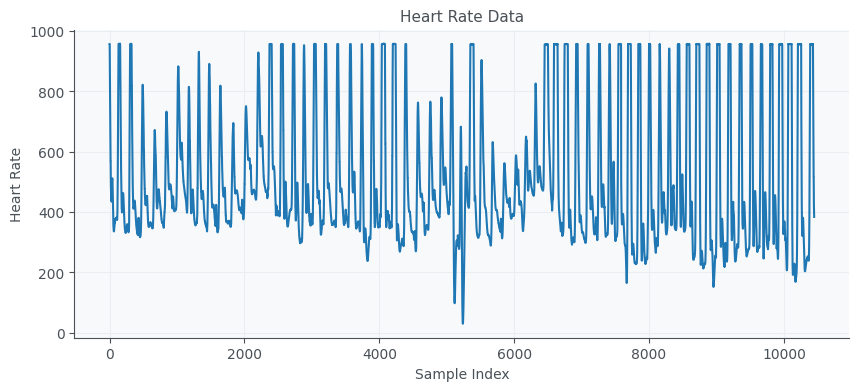

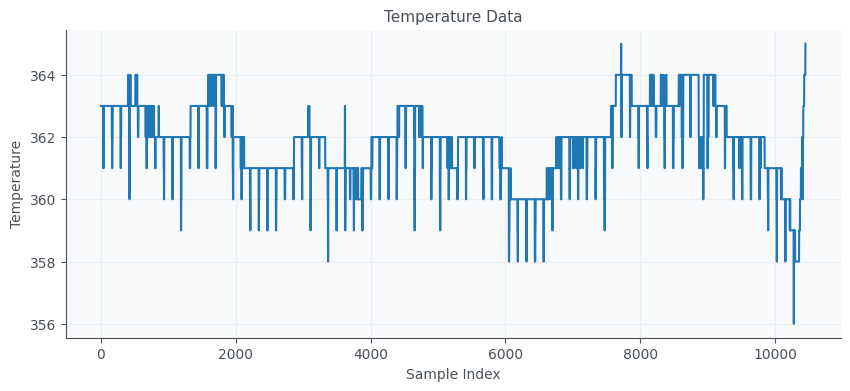

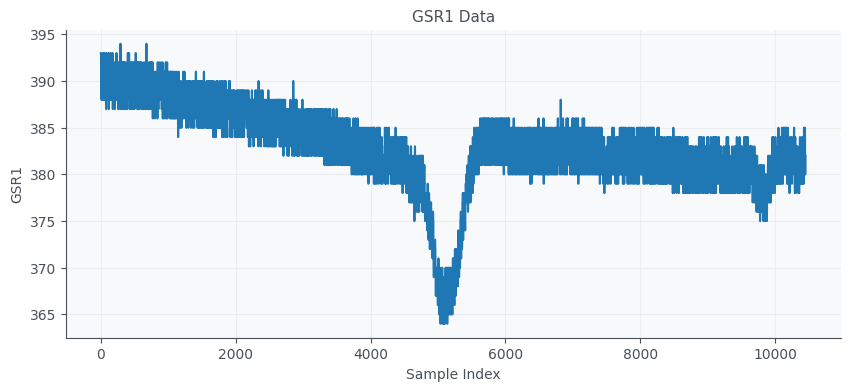

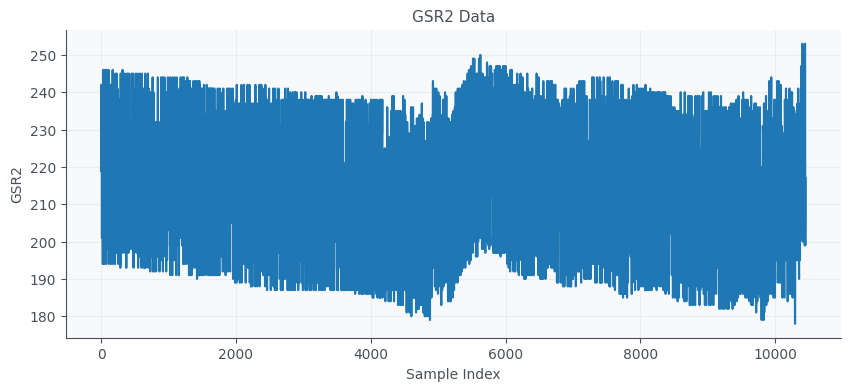

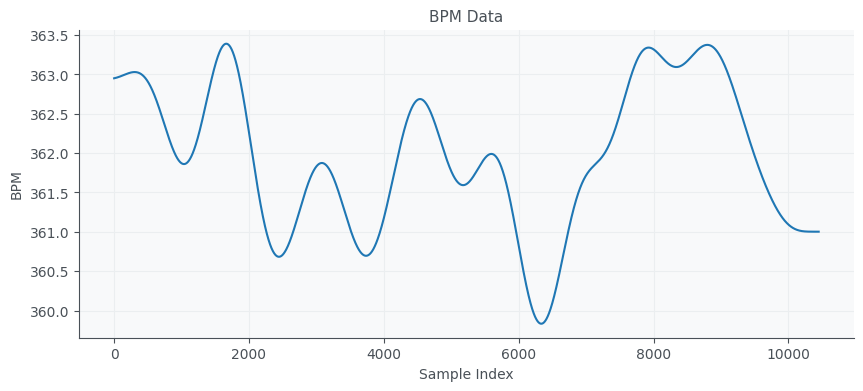

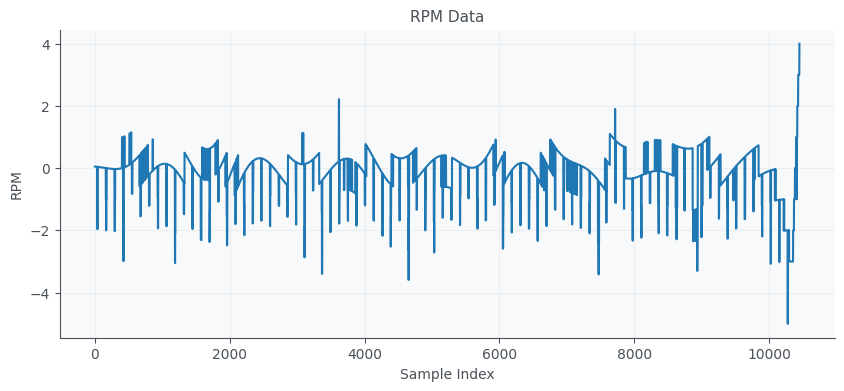

In [171]:
import matplotlib.pyplot as plt

# Initialize lists to store the data
heart_data = []
temp_data = []
gsr1_data = []
gsr2_data = []
bpm_data  = []
rpm_data  = []

# Extract data from the dataset
for i in range(len(dataset)):
    sample = dataset[i]
    heart_data.append(sample[0])
    temp_data.append(sample[1])
    gsr1_data.append(sample[2])
    gsr2_data.append(sample[3])
    bpm_data.append(sample[9])
    rpm_data.append(sample[10])

# Plot HEART data
plt.figure(figsize=(10, 4))
plt.plot(heart_data)
plt.title('Heart Rate Data')
plt.xlabel('Sample Index')
plt.ylabel('Heart Rate')
plt.show()

# Plot TEMP data
plt.figure(figsize=(10, 4))
plt.plot(temp_data)
plt.title('Temperature Data')
plt.xlabel('Sample Index')
plt.ylabel('Temperature')
plt.show()

# Plot GSR1 data
plt.figure(figsize=(10, 4))
plt.plot(gsr1_data)
plt.title('GSR1 Data')
plt.xlabel('Sample Index')
plt.ylabel('GSR1')
plt.show()

# Plot GSR2 data
plt.figure(figsize=(10, 4))
plt.plot(gsr2_data)
plt.title('GSR2 Data')
plt.xlabel('Sample Index')
plt.ylabel('GSR2')
plt.show()


# Plot BPM data
plt.figure(figsize=(10, 4))
plt.plot(bpm_data)
plt.title('BPM Data')
plt.xlabel('Sample Index')
plt.ylabel('BPM')
plt.show()


# Plot BPM data
plt.figure(figsize=(10, 4))
plt.plot(rpm_data)
plt.title('RPM Data')
plt.xlabel('Sample Index')
plt.ylabel('RPM')
plt.show()


# Processing Heart Data

In [47]:
# Extracting raw signal and filtering
#signals = normalize01(signals)
#signals = enveloppe_filter(signals_clean)

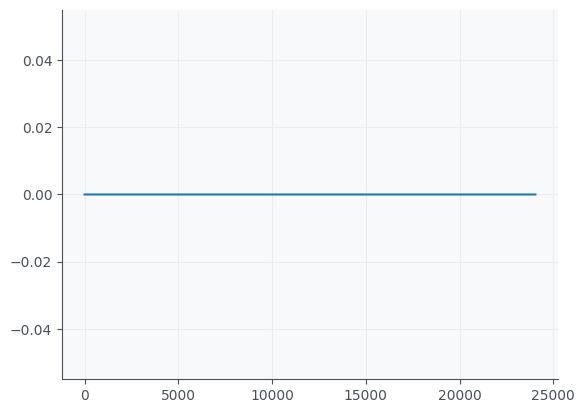

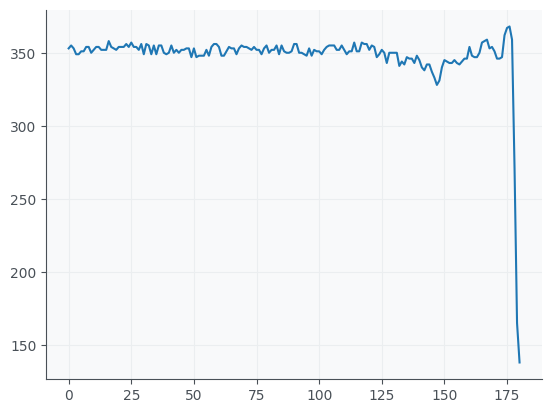

In [137]:
plt.figure()
gsr = signals[:,1]
plt.plot(gsr)
plt.figure()
gsr = signals[::50, 3]
start = 300
plt.plot(gsr[start:start+256])

In [37]:
print(t[:10])

NameError: name 't' is not defined

Text(0.5, 1.0, 'Intervals')

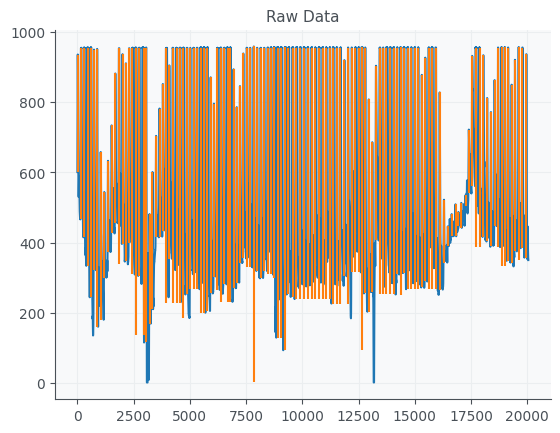

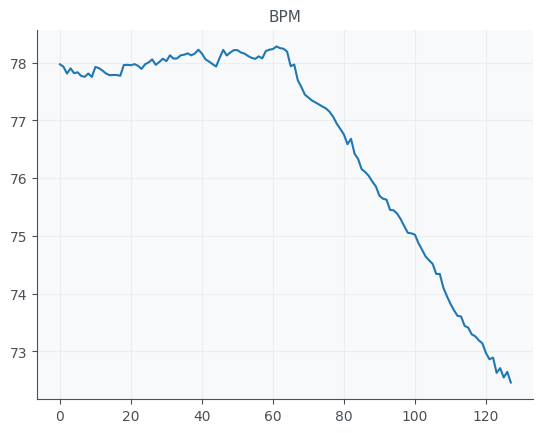

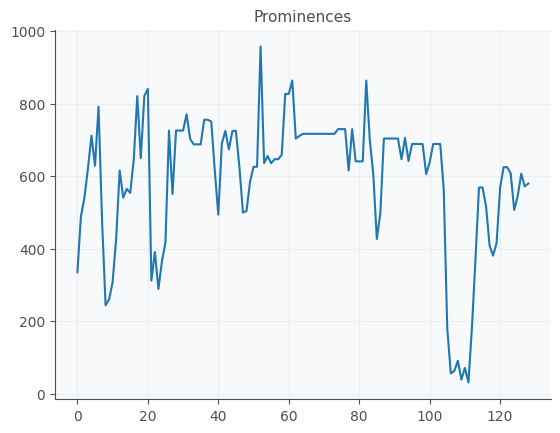

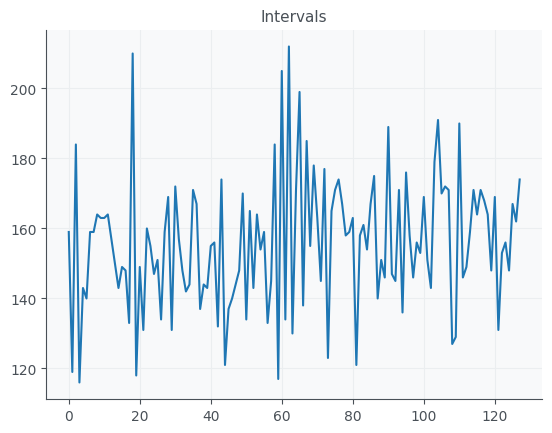

In [145]:
# Sanity check to see if peak detection works correctly
crop_time = 10
sampling_rate = 200

distance = 100
width = None
prominence = 0.01
smoothing = True
size = sampling_rate


t = signals[:,0]
bvp_raw = signals[:,2]
#eda_raw = signals[:,2]


data = bvp_raw[crop_time*sampling_rate:-crop_time*sampling_rate]
data_stream = DataStream(data)

peaks, properties = find_peaks(data, distance=distance, width=width, prominence=prominence)
#print(peaks, properties)
bpm = get_heart_rate(peaks, sampling_rate=sampling_rate, smooth=smoothing, size=size)
intervals = compute_intervals(peaks)

plt.figure()
plt.plot(data)
plt.title("Raw Data")
plt.vlines(x=peaks, ymin=data[peaks] - properties["prominences"], ymax = data[peaks], color = "C1")

plt.figure()
plt.plot(bpm[1])
plt.title("BPM")

plt.figure()
plt.plot(properties["prominences"])
plt.title("Prominences")

plt.figure()
plt.plot(intervals)
plt.title("Intervals")

[]
0 112


ValueError: x and y must have same first dimension, but have shapes (0,) and (102,)

ValueError: Image size of 573x312737 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x480 with 1 Axes>

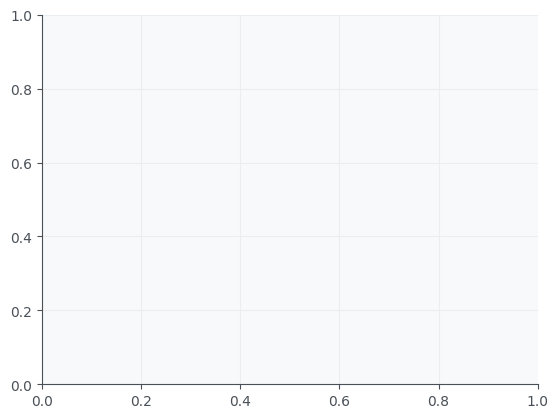

In [91]:
# Compute bpm for the whole data
size = 100
smoothing = True
peaks, properties = find_peaks(bvp_raw, distance=distance, width=width, prominence=prominence)
bpm = get_heart_rate(peaks, sampling_rate=1000, smooth=smoothing, size=size)
intervals = compute_intervals(peaks)
amplitudes = properties["prominences"]
if smoothing:
    intervals, _ = smoother(signal=intervals, kernel='boxcar', size=size, mirror=True)
    amplitudes, _ = smoother(signal=amplitudes, kernel='boxcar', size=size, mirror=True)
    
print(bpm[0])
print(len(bpm[1]), len(peaks))
plt.figure()
plt.plot(bpm[0], bpm[1])
plot_emotions(93)
plt.title("bpm")
plt.figure()
plt.plot(bpm[0], amplitudes[5:-5])
plot_emotions(0.6)
plt.figure()
plt.plot(bpm[0], intervals[5:-4])
#plot_emotions(6000)

# Processing Sweat Data

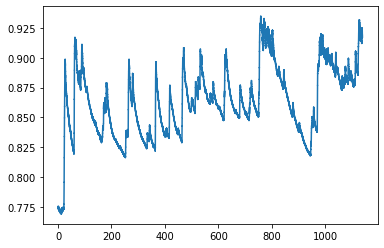

In [41]:
# Extracting raw signal and filtering
t = signals[:,0][10:]
eda_raw = signals[:,2]
eda_raw = enveloppe_filter(eda_raw)[10:]
plt.figure()
plt.plot(t, eda_raw)

In [46]:
print(t[:10])

[0.00760278 0.00836306 0.00912333 0.00988361 0.01064389 0.01140417
 0.01216444 0.01292472 0.013685   0.01444528]


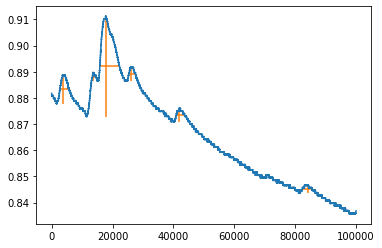

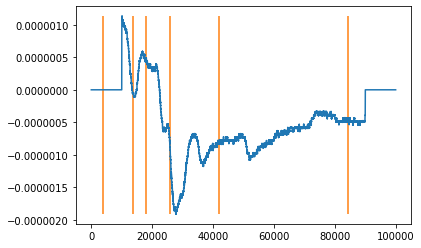

In [93]:
# Sanity check to see if peak detection works correctly
start = 1
window_size = 100000
width = 600
distance = 1800
prominence = 0.0014
size = 10000

data = eda_raw[start*window_size:(start+1)*window_size]
peaks, properties = find_peaks(data, width=width, distance=distance, prominence=prominence)
plt.figure()
plt.plot(data)
plt.vlines(x=peaks, ymin=data[peaks] - properties["prominences"], ymax = data[peaks], color = "C1")
plt.hlines(y=properties["width_heights"], xmin=properties["left_ips"], xmax=properties["right_ips"], color = "C1")

rate = rate_of_change(data, size=size)
plt.figure()
plt.plot(rate)
plt.vlines(x=peaks, ymin=rate.min(), ymax=rate.max(), color = "C1")

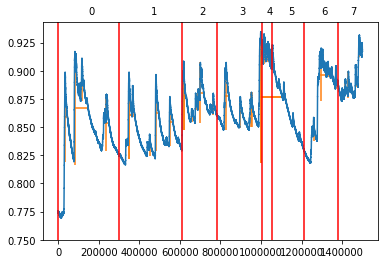

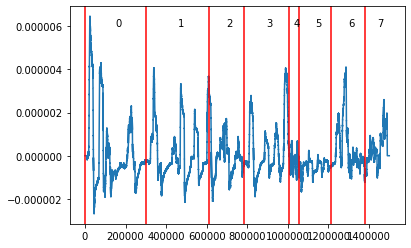

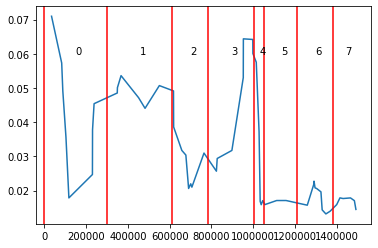

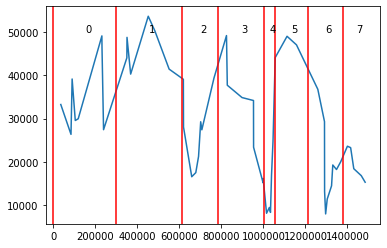

In [150]:
# Compute bpm for the whole data
smoothing = True
size = 5
peaks, properties = find_peaks(eda_raw, width=width, distance=distance, prominence=prominence)

intervals = compute_intervals(peaks)
amplitudes = properties["prominences"]
if smoothing:
    intervals, _ = smoother(signal=intervals, kernel='boxcar', size=size, mirror=True)
    amplitudes, _ = smoother(signal=amplitudes, kernel='boxcar', size=size, mirror=True)

rate = rate_of_change(eda_raw, size=10000)

plt.figure()
plt.plot(eda_raw)
plt.vlines(x=peaks, ymin=eda_raw[peaks] - properties["prominences"], ymax = eda_raw[peaks], color = "C1")
plt.hlines(y=properties["width_heights"], xmin=properties["left_ips"], xmax=properties["right_ips"], color = "C1")
plt.ylim(bottom=0.75)
plot_emotions(0.950)

plt.figure()
plt.plot(rate)
plot_emotions(0.000006)
#plt.vlines(x=peaks, ymin=rate.min(), ymax=rate.max(), color = "C1")

plt.figure()
plt.plot(peaks, amplitudes)
plot_emotions(0.06)

plt.figure()
plt.plot(peaks[:-1], intervals)
plot_emotions(50000)



# Old Draft

<IPython.core.display.Javascript object>


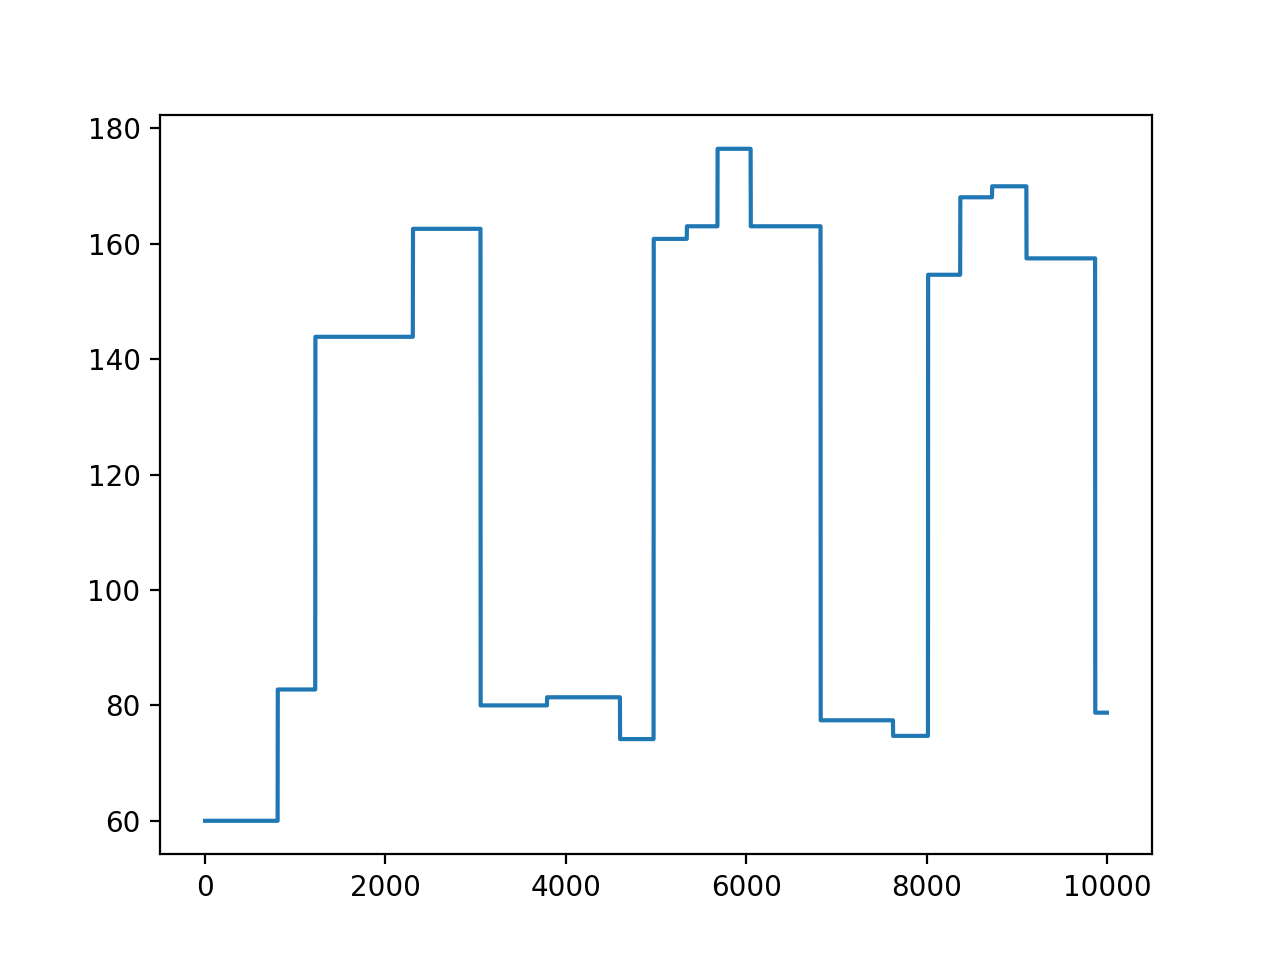

<IPython.core.display.Javascript object>


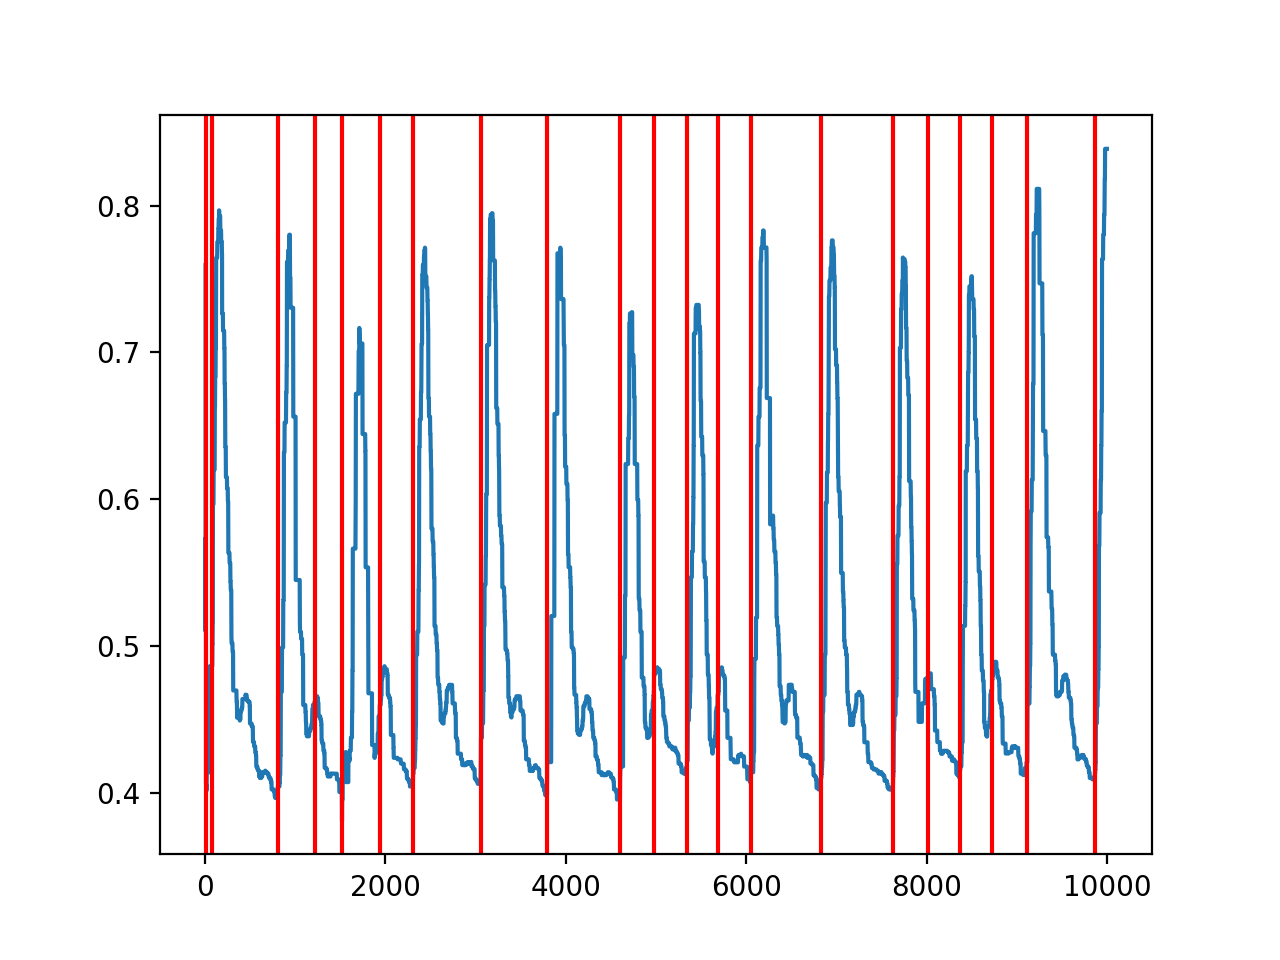

In [21]:
plt.figure()
plt.plot(bpm)
plt.figure()
plt.plot(data)
for p in peaks:
    plt.axvline(x=p, color="red")

In [19]:
bpm = []
peaks = []
data_stream.reset()
heart.reset()
t = tqdm.tqdm(total=len(data_stream))
while data_stream.hasNext():
    heart.update()
    bpm.append(heart.getBPM())
    if heart.beat:
        peaks.append(data_stream.i)
    t.update()
#plt.figure()
#plt.plot(bpm)





  0%|          | 0/10000 [00:00<?, ?it/s]



 14%|█▍        | 1450/10000 [00:00<00:00, 14499.12it/s]



 31%|███▏      | 3143/10000 [00:00<00:00, 15150.36it/s]



 48%|████▊     | 4788/10000 [00:00<00:00, 15517.06it/s]



 66%|██████▌   | 6569/10000 [00:00<00:00, 16140.16it/s]



 84%|████████▎ | 8361/10000 [00:00<00:00, 16634.03it/s]

0 91.36567574423589 27.963134070298473 167.06178433557625 48.47187976971598
1 86.4122238628553 22.13792246164303 174.76926821416936 43.157232696999046
2 99.87782102690699 28.166845668204775 188.72577886441746 49.600639580049325
3 91.19471747939987 25.664803632780835 180.83528493364557 41.251298652861095
4 79.26850233488189 19.60606086980825 128.80039704629928 45.371063286932504
5 92.96846489558 23.366972545931294 153.53772496575456 48.118994671428524
6 89.32906813520668 22.28745047042183 172.75894486534312 51.42220806939261
7 85.11940032986234 19.100313541203 146.54522378588226 56.69859960003638


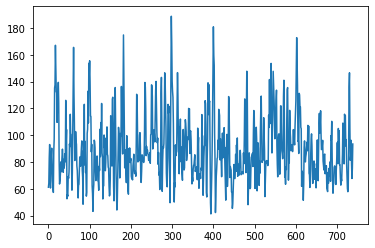

In [28]:
intervals = [0, 300000, 611000, 783000, 1004000, 1054000, 1211000, 1381000, -1] 
for i in range(len(intervals)-1):
    start_time = bvp_signal[0][intervals[i]]
    end_time = bvp_signal[0][intervals[i+1]]
    
    mask =  np.logical_and(start_time <= bvp_signal[3], bvp_signal[3] <= end_time)
    signal = bvp_signal[4][mask]
    mean = signal.mean()
    std = signal.std()
    print(i, mean, std, signal.max(), signal.min())
    
plt.figure()
plt.plot(bvp_signal[4])

(1499452, 3)


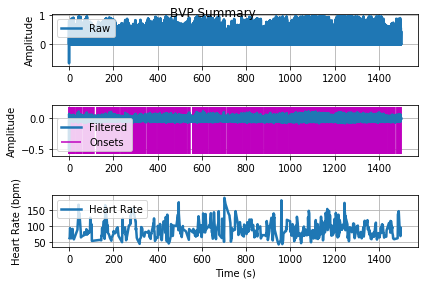

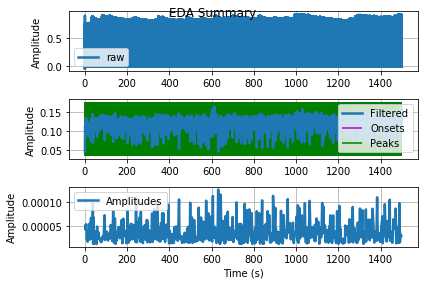

In [36]:
# This is broken !
sampling_rate = 1000
min_amplitude = 0.1
print(signals.shape)
t = signals[:,0]
bvp_raw = signals[:,1]
eda_raw = signals[:,2]

bvp_signal = bvp.bvp(bvp_raw, sampling_rate=sampling_rate)
eda_signal = eda.eda(eda_raw, sampling_rate=sampling_rate, min_amplitude=min_amplitude)

0 3.5785178601031196 1.7726173722164287 10.805710024553518 1.2734876433297264
1 3.665426139086279 2.15415911102666 11.243946392239307 1.3985124959390112
2 3.7618897859638696 2.366425456758715 12.57306211980875 1.2930250303773005
3 3.767224635726514 2.0855803211960056 11.266490084683793 1.263277901883984
4 4.263630023565308 2.39979271082286 9.757770116452141 1.396712819756155
5 3.7901524609925663 2.0242265324162747 10.231666158276816 1.291870460592724
6 3.513107509386987 1.9150238506360442 8.969685690700196 1.3059418386224897
7 4.151707761268728 2.46638215161853 10.966923173694648 1.4297145760155725


<IPython.core.display.Javascript object>


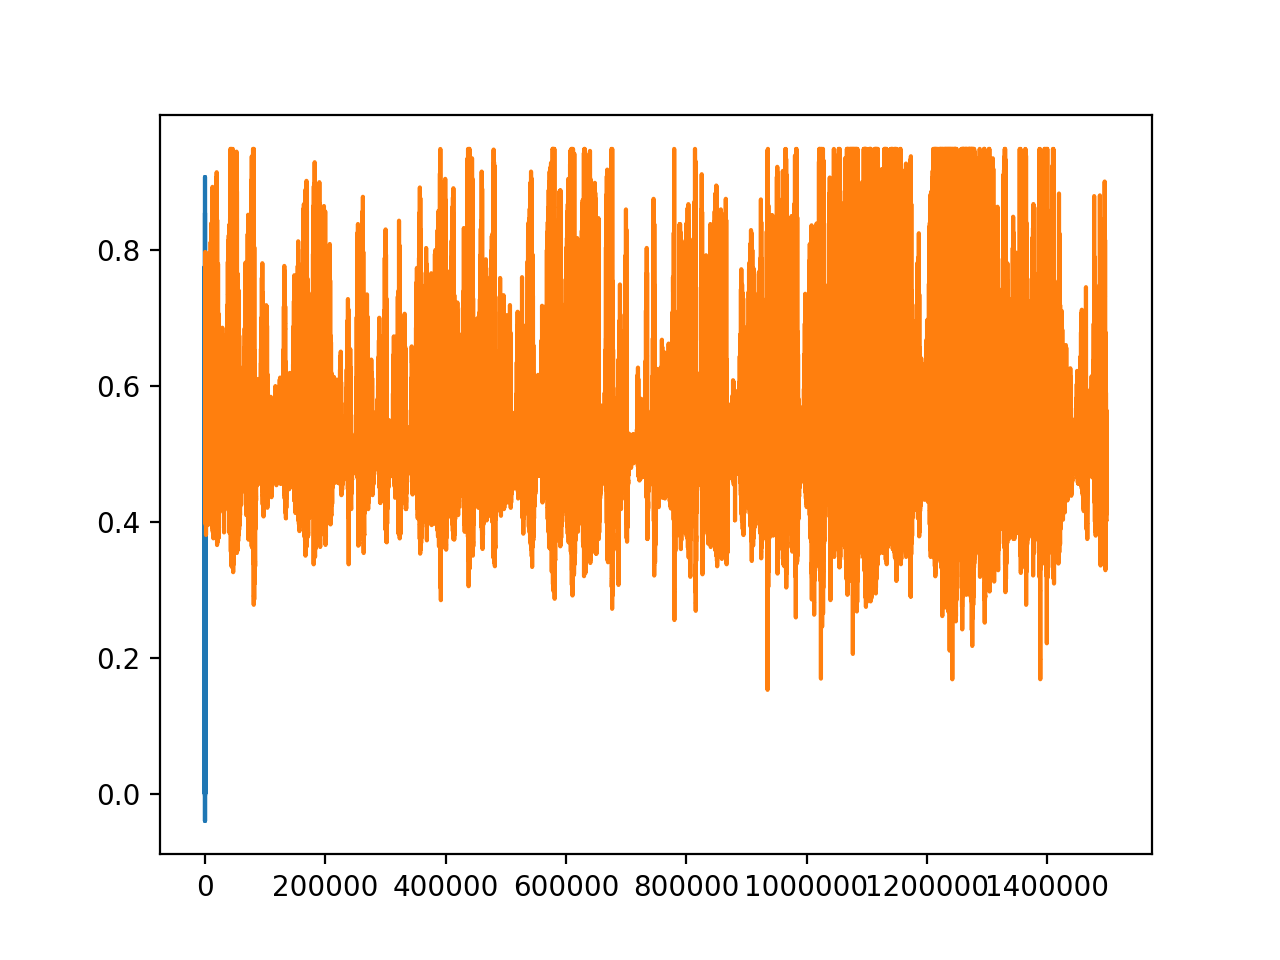

In [50]:
intervals = [0, 300000, 611000, 783000, 1004000, 1054000, 1211000, 1381000, 1505000] 
for i in range(len(intervals)-1):
    mask =  np.logical_and(intervals[i] <= eda_signal[3], eda_signal[3] <= intervals[i+1])
    signal = eda_signal[4][mask]*1e5
    mean = signal.mean()
    std = signal.std()
    print(i, mean, std, signal.max(), signal.min())
    

plt.figure()
plt.plot(eda_signal[0][:100], eda_raw[:100])

<IPython.core.display.Javascript object>


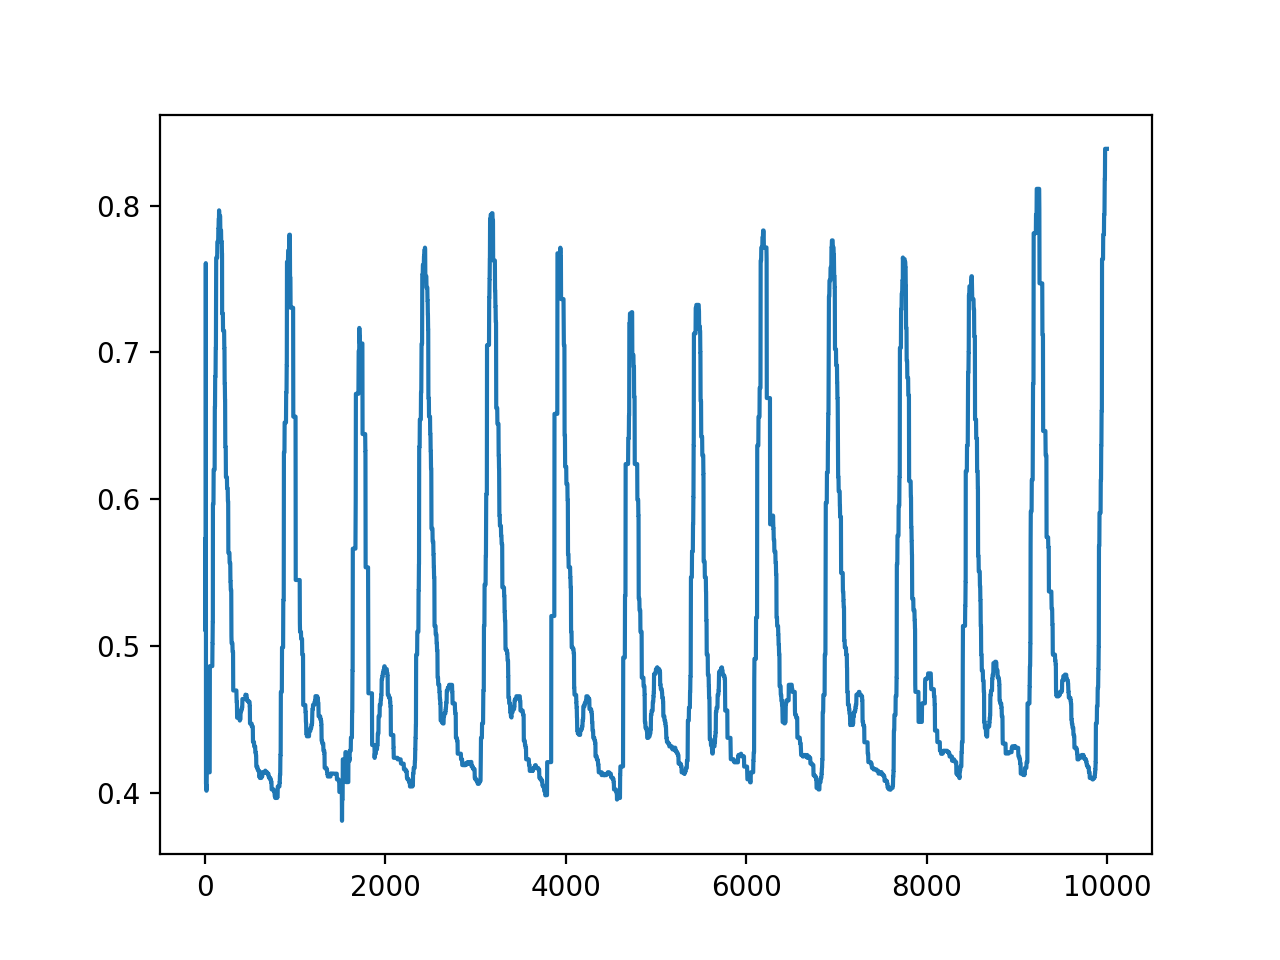

In [111]:
plt.figure()
plt.plot(filtered_bvp[:10000])

In [102]:
filtered_eda = enveloppe_filter(eda_raw)[20:]

<IPython.core.display.Javascript object>


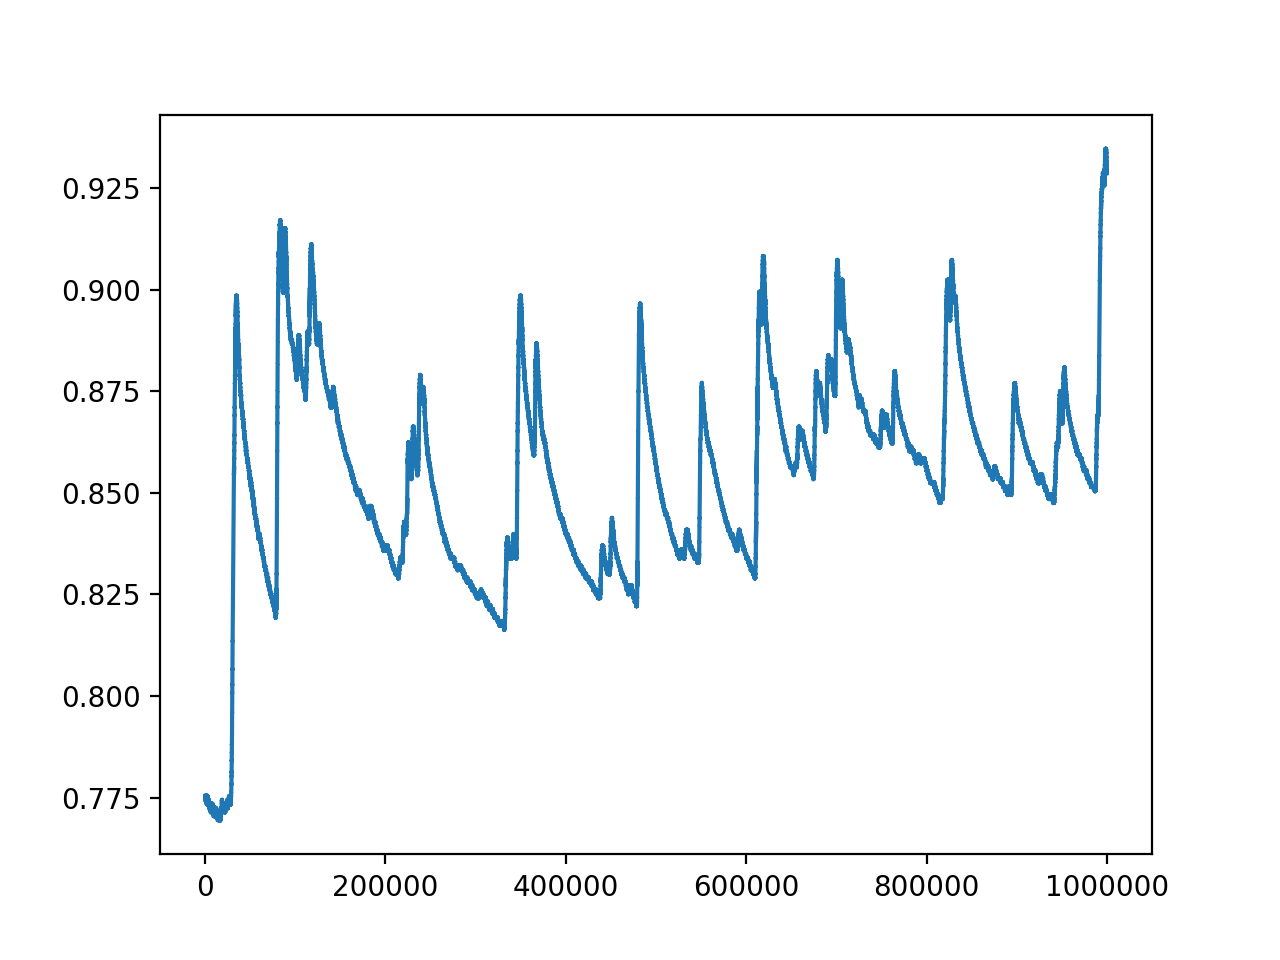

In [122]:
plt.figure()
plt.plot(filtered_eda[:1000000])

<IPython.core.display.Javascript object>


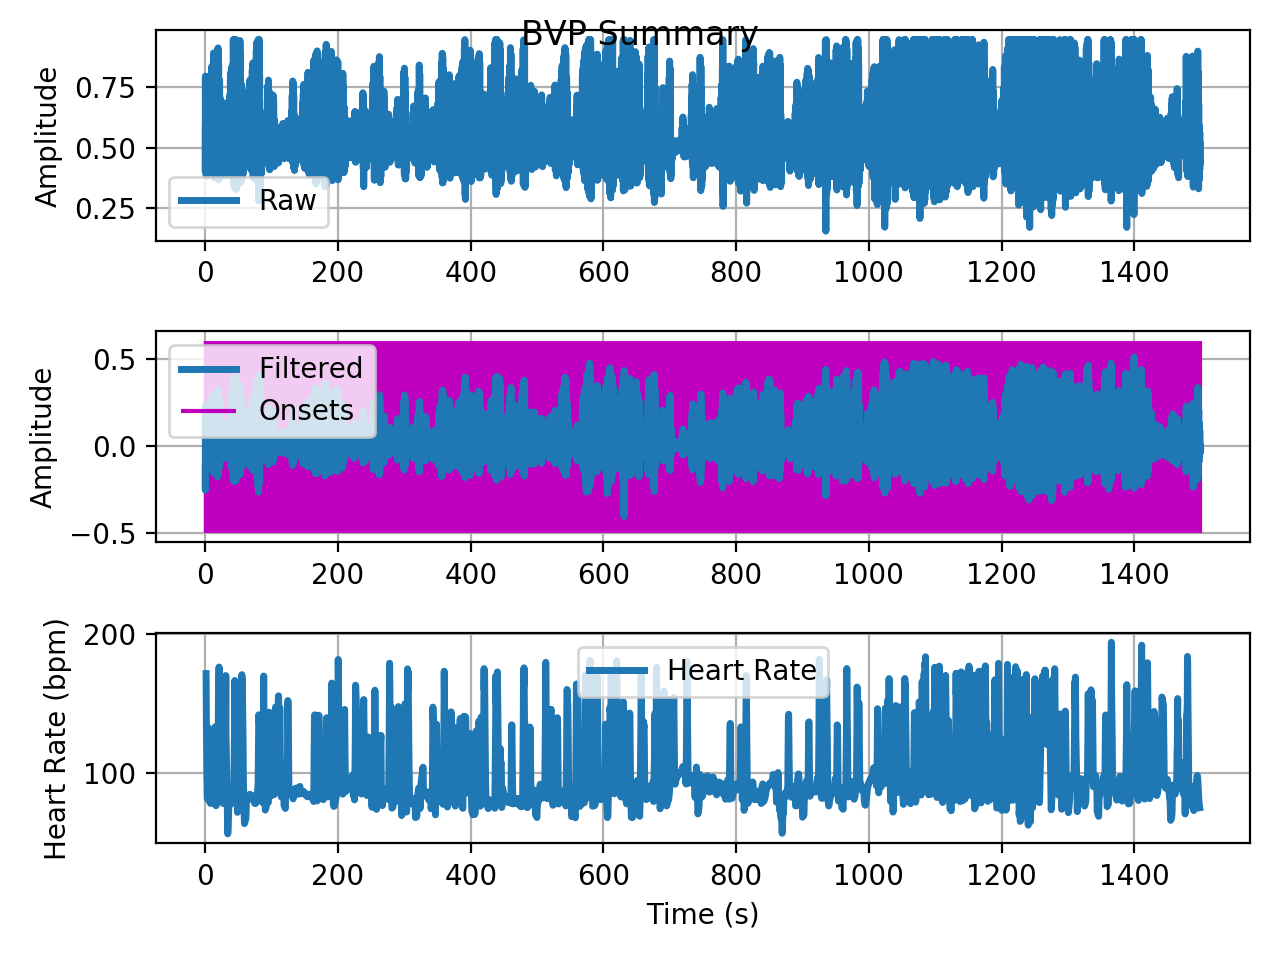

In [114]:
bvp_signal = bvp.bvp(filtered_bvp[:-1], sampling_rate=sampling_rate)

#eda_signal = eda.eda(filtered_eda, sampling_rate=sampling_rate, min_amplitude=min_amplitude)

(1499432,) 0.769287109375
(1499452,)


<IPython.core.display.Javascript object>


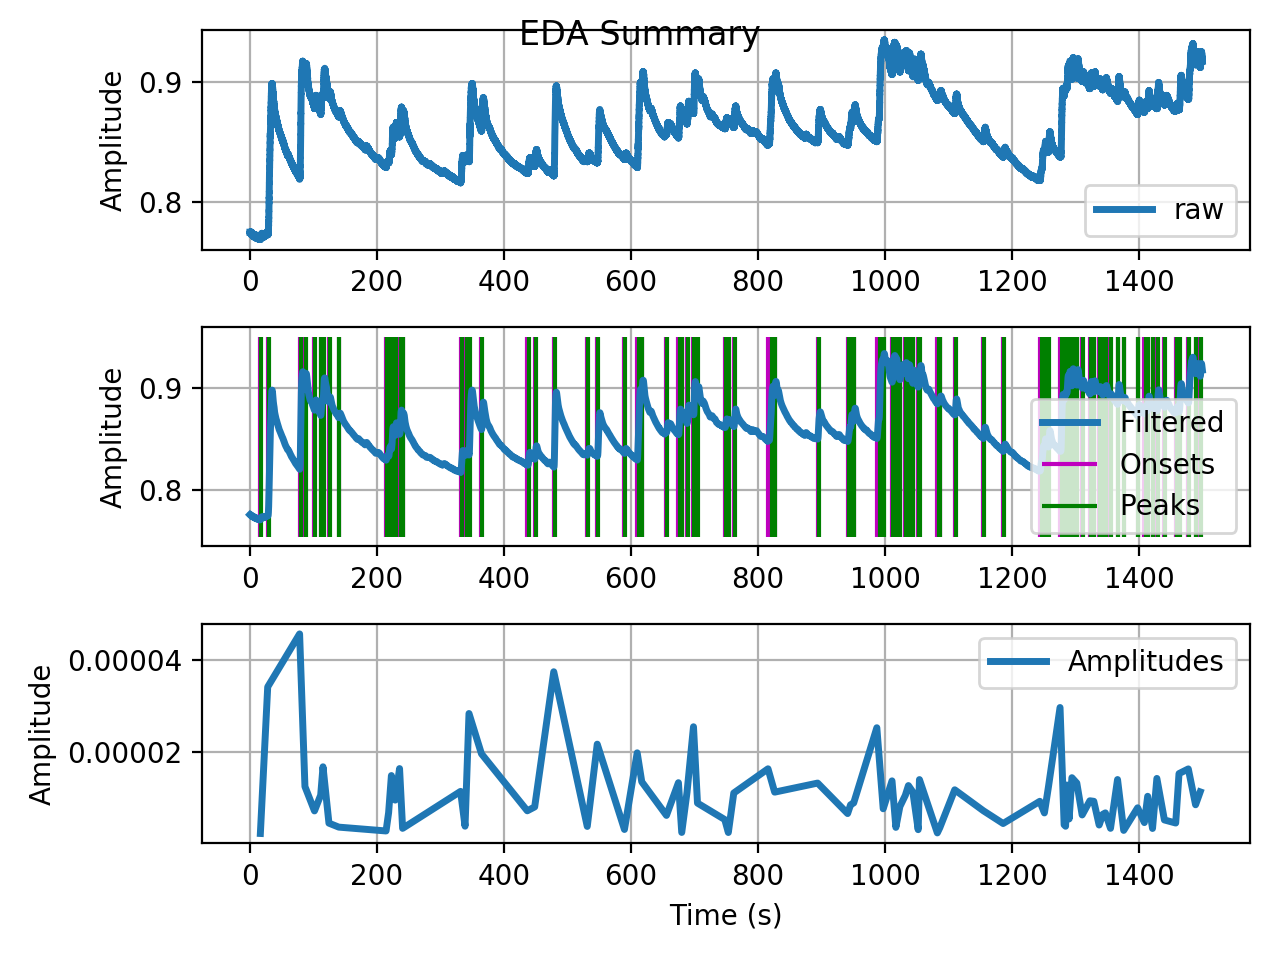

In [107]:
print(filtered_eda.shape, filtered_eda.min())
print(eda_raw.shape)
eda_signal = eda.eda(filtered_eda, sampling_rate=1000, min_amplitude=0.05)

In [108]:
intervals = [0, 300000, 611000, 783000, 1004000, 1054000, 1211000, 1381000, -1]
for i in range(len(intervals)-1):
    start_time = bvp_signal[0][intervals[i]]
    end_time = bvp_signal[0][intervals[i+1]]
    
    mask =  np.logical_and(start_time <= bvp_signal[3], bvp_signal[3] <= end_time)
    signal = bvp_signal[4][mask]
    mean = signal.mean()
    std = signal.std()
    print(i, mean, std, signal.max(), signal.min())

0 101.27088352938462 26.6266549992748 181.60538197223494 56.09627958011256
1 101.39130478667643 29.33674802164093 180.93788061839177 65.98404523478214
2 101.58525053546256 24.656927135717254 180.5983055836948 67.72677390864511
3 94.11682514655374 19.964625895229013 181.84958121060356 56.48043022783865
4 108.80647481598778 22.938186613107412 167.83930932284613 71.73825478345039
5 115.21192943409302 33.27928338259362 183.57347862396932 72.73516350502538
6 114.05654906148347 31.675351945992915 176.4518761323873 60.76692046355905
7 101.97947982679452 25.194965089182553 183.7936180099581 65.82542880945999


In [117]:
hr = get_heart_rate(filtered_bvp, sampling_rate=sampling_rate)

/opt/miniconda3/lib/python3.7/site-packages/biosppy/signals/tools.py:1435: RuntimeWarning: divide by zero encountered in true_divide
  hr = sampling_rate * (60. / np.diff(beats))


In [122]:
def test(x=3):
    print(x)

test(**[dict(x=1), dict(x=2)][1])

2
